In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import librosa
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU

def feature_extractor_40(audio_file):
    # 확장자가 .wav 또는 .mp3인지 확인
    if audio_file.endswith('.wav') or audio_file.endswith('.mp3'):
        audio, sample_rate = librosa.load(audio_file)
        mffcs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_40 = np.mean(mffcs_features.T, axis=0)

        # print('mfccs_features_40', mfccs_features_40.shape, mfccs_features_40)
        return mfccs_features_40
    else:
        return None  # 올바르지 않은 파일 확장자 처리

def feature_extractor_80(audio_file):
    # 확장자가 .wav 또는 .mp3인지 확인
    if audio_file.endswith('.wav') or audio_file.endswith('.mp3'):
        audio, sample_rate = librosa.load(audio_file)
        mffcs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
        mfccs_features_80 = np.mean(mffcs_features.T, axis=0)
        # print('mfccs_features_80', mfccs_features_80.shape, mfccs_features_80)
        return mfccs_features_80
    else:
        return None  # 올바르지 않은 파일 확장자 처리

def scaler1(mfcc_features):
    scaler_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/first_model_scaler.pkl'
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    mfcc_features_scaled = scaler.transform([mfcc_features])

    return mfcc_features_scaled

def scaler2(mfcc_features):
    scaler_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/second_model_scaler.pkl'
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    mfcc_features_scaled = scaler.transform([mfcc_features])

    return mfcc_features_scaled

def differential_mfcc(mfcc_value):
    mfcc_features = np.array(mfcc_value)  # Pandas 값 변환 수정
    delta_mfccs = librosa.feature.delta(mfcc_features, order=1)         # ΔMFCC (1차 미분, 40개) 계산
    delta2_mfccs = librosa.feature.delta(mfcc_features, order=2)        # ΔΔMFCC (2차 미분, 40개) 계산

    concat_features = np.hstack((mfcc_features, delta_mfccs, delta2_mfccs))  # (샘플 수, 120)

    return concat_features

def process1(audio):
    mfcc1 = feature_extractor_40(audio)
    if mfcc1 is None:
        return None
    mfcc2 = scaler1(mfcc1)
    mfcc3 = differential_mfcc(mfcc2)
    # print('first mfcc3', mfcc3.shape, mfcc3)
    return mfcc3

def process2(audio):
    mfcc1 = feature_extractor_80(audio)
    if mfcc1 is None:
        return None
    mfcc2 = differential_mfcc(mfcc1)
    mfcc3 = scaler2(mfcc2)
    # print('second mfcc3', mfcc3.shape, mfcc3)
    return mfcc3


def model1(mfcc_features):
    # print('first_model_input', mfcc_features.shape, mfcc_features)
    model_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/first_model_sim1.keras'
    model = load_model(model_path, custom_objects={'LeakyReLU': LeakyReLU})  # 모델 로드

    pred = model.predict(mfcc_features)  # 예측 수행
    pred_class = (pred < 0.5).astype(int)  # 확률값을 이진 분류로 변환

    # if pred_class == 0:
    #     print('병원X')
    # else:
    #     print('병원O')

    return pred_class

def model2(mfcc_features):
    # print('second_model_input', mfcc_features.shape, mfcc_features)
    model_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/second_model_sim2_mfcc80.keras'
    model = load_model(model_path, custom_objects={'LeakyReLU': LeakyReLU})
    label_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/second_model_label_encoder.pkl'
    with open(label_path, 'rb') as f:
        label_encoder = pickle.load(f)

    pred = model.predict(mfcc_features)
    pred_class_index = np.argmax(pred)
    pred_class_name = label_encoder.inverse_transform([pred_class_index])[0]

    # if pred_class_index == 0:
    #     print('awake, 깸')
    # elif pred_class_index == 1:
    #     print('diaper, 귀저기갈아야함')
    # elif pred_class_index == 2:
    #     print('hug, 안아줘야함')
    # elif pred_class_index == 3:
    #     print('hungry, 배고픔')
    # elif pred_class_index == 4:
    #     print('sleepy, 졸림')
    # else:
    #     print('모델예측잘못됨')
    return pred_class_name


def pipeline(audio_file_path):
    mfcc1 = process1(audio_file_path)
    mfcc2 = process2(audio_file_path)
    pred1 = model1(mfcc1)
    pred2 = model2(mfcc2)

    print('최종결과-------------')
    if pred1 == 0:
        print(pred2)
    else:
        print('당장 병원 ㄱㄱ')


In [11]:

sample_audio_awake1 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_awake/510_snippet_1.wav'
sample_audio_awake2 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_awake/594_snippet_2.wav'
sample_audio_awake3 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_awake/643_snippet_1.wav'
sample_audio_awake4 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_awake/735_snippet_1.wav'
sample_audio_awake5 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_awake/792_snippet_1.wav'


In [12]:
# from preprocess1 import *

pipeline( sample_audio_awake1)
print('sample_audio_awake1','*'*20)

pipeline( sample_audio_awake2)
print('sample_audio_awake2','*'*20)

pipeline( sample_audio_awake3)
print('sample_audio_awake3','*'*20)

pipeline( sample_audio_awake4)
print('sample_audio_awake4','*'*20)

pipeline( sample_audio_awake5)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
최종결과-------------
awake
sample_audio_awake1 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
최종결과-------------
awake
sample_audio_awake2 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
최종결과-------------
awake
sample_audio_awake3 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
최종결과-------------
awake
sample_audio_awake4 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
최종결과-------------
awake


In [14]:
sample_audio_diaper1 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_diaper/161_snippet_2.wav'
sample_audio_diaper2 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_diaper/201_snippet_2.wav'
sample_audio_diaper3 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_diaper/286_snippet_1.wav'
sample_audio_diaper4 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_diaper/7_snippet_1.wav'
sample_audio_diaper5 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_diaper/213_snippet_2.wav'

In [15]:
# from preprocess1 import *

pipeline( sample_audio_diaper1)
print('sample_audio_diaper1','*'*20)

pipeline( sample_audio_diaper2)
print('sample_audio_diaper2','*'*20)

pipeline( sample_audio_diaper3)
print('sample_audio_diaper3','*'*20)

pipeline( sample_audio_diaper4)
print('sample_audio_diaper4','*'*20)

pipeline( sample_audio_diaper5)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
최종결과-------------
diaper
sample_audio_diaper1 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
최종결과-------------
diaper
sample_audio_diaper2 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
최종결과-------------
diaper
sample_audio_diaper3 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
최종결과-------------
diaper
sample_audio_diaper4 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
최종결과-------------
diaper


In [21]:
sample_audio_hug1 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/109_snippet_2.wav'
sample_audio_hug2 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/207_snippet_1.wav'
sample_audio_hug3 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/235_snippet_1.wav'
sample_audio_hug4 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/342_snippet_1.wav'
sample_audio_hug5 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/495_snippet_2.wav'

In [20]:
# from preprocess1 import *

pipeline( sample_audio_hug1)
print('sample_audio_hug1','*'*20)

pipeline( sample_audio_hug2)
print('sample_audio_hug2','*'*20)

pipeline( sample_audio_hug3)
print('sample_audio_hug3','*'*20)

pipeline( sample_audio_hug4)
print('sample_audio_hug4','*'*20)

pipeline( sample_audio_hug5)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
최종결과-------------
hug
sample_audio_hug1 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
최종결과-------------
hug
sample_audio_hug2 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
최종결과-------------
hug
sample_audio_hug3 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
최종결과-------------
hug
sample_audio_hug4 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
최종결과-------------
hug


In [22]:
sample_audio_hungry1 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hungry/348_snippet_2.wav'
sample_audio_hungry2 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hungry/407_snippet_2.wav'
sample_audio_hungry3 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hungry/467_snippet_1.wav'
sample_audio_hungry4 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hungry/579_snippet_1.wav'
sample_audio_hungry5 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hungry/hungry_106_snippet_1.wav'

In [23]:
# from preprocess1 import *

pipeline( sample_audio_hungry1)
print('sample_audio_hungry1','*'*20)

pipeline( sample_audio_hungry2)
print('sample_audio_hungry2','*'*20)

pipeline( sample_audio_hungry3)
print('sample_audio_hungry3','*'*20)

pipeline( sample_audio_hungry4)
print('sample_audio_hungry4','*'*20)

pipeline( sample_audio_hungry5)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
최종결과-------------
hungry
sample_audio_hungry1 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
최종결과-------------
hungry
sample_audio_hungry2 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
최종결과-------------
hungry
sample_audio_hungry3 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
최종결과-------------
hungry
sample_audio_hungry4 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
최종결과-------------
hungry


In [8]:
sample_audio_sleepy1 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_sleepy/122_snippet_2.wav'
sample_audio_sleepy2 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_sleepy/214_snippet_1.wav'
sample_audio_sleepy3 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_sleepy/778_snippet_2.wav'
sample_audio_sleepy4 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_sleepy/905_snippet_1.wav'
sample_audio_sleepy5 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_sleepy/98_snippet_1.wav'

In [24]:
# from preprocess1 import *

pipeline( sample_audio_sleepy1)
print('sample_audio_sleepy1','*'*20)

pipeline( sample_audio_sleepy2)
print('sample_audio_sleepy2','*'*20)

pipeline( sample_audio_sleepy3)
print('sample_audio_sleepy3','*'*20)

pipeline( sample_audio_sleepy4)
print('sample_audio_sleepy4','*'*20)

pipeline( sample_audio_sleepy5)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
최종결과-------------
sleepy
sample_audio_sleepy1 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
최종결과-------------
sleepy
sample_audio_sleepy2 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
최종결과-------------
sleepy
sample_audio_sleepy3 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
최종결과-------------
sleepy
sample_audio_sleepy4 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
최종결과-------------
sleepy


In [53]:
sample_audio_pain1 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/174_snippet_1.wav'
sample_audio_pain2 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/174_snippet_2.wav'
sample_audio_pain3 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/197_snippet_1.wav'
sample_audio_pain4 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_hug/197_snippet_2.wav'
sample_audio_pain5 = '/content/drive/MyDrive/Aivle_빅프/china_sep/sep_sleepy/181_snippet_1.wav'

In [55]:
# from preprocess1 import *

pipeline( sample_audio_pain1)
print('sample_audio_pain1','*'*20)

pipeline( sample_audio_pain2)
print('sample_audio_pain2','*'*20)

pipeline( sample_audio_pain3)
print('sample_audio_pain3','*'*20)

pipeline( sample_audio_pain4)
print('sample_audio_pain4','*'*20)

pipeline( sample_audio_pain5)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
최종결과-------------
당장 병원 ㄱㄱ
sample_audio_pain1 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
최종결과-------------
당장 병원 ㄱㄱ
sample_audio_pain2 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
최종결과-------------
당장 병원 ㄱㄱ
sample_audio_pain3 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
최종결과-------------
당장 병원 ㄱㄱ
sample_audio_pain4 ********************


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
최종결과-------------
당장 병원 ㄱㄱ


In [58]:
import shutil
import os
from google.colab import files

# 다운로드할 파일 리스트 (예제: 변수명을 키로 설정)
sample_audio_files = {
    "sample_audio_awake1": sample_audio_awake1,
    "sample_audio_awake2": sample_audio_awake2,
    "sample_audio_awake3": sample_audio_awake3,
    "sample_audio_awake4": sample_audio_awake4,
    "sample_audio_awake5": sample_audio_awake5,
    "sample_audio_diaper1": sample_audio_diaper1,
    "sample_audio_diaper2": sample_audio_diaper2,
    "sample_audio_diaper3": sample_audio_diaper3,
    "sample_audio_diaper4": sample_audio_diaper4,
    "sample_audio_diaper5": sample_audio_diaper5,
    "sample_audio_sleepy1": sample_audio_sleepy1,
    "sample_audio_sleepy2": sample_audio_sleepy2,
    "sample_audio_sleepy3": sample_audio_sleepy3,
    "sample_audio_sleepy4": sample_audio_sleepy4,
    "sample_audio_sleepy5": sample_audio_sleepy5,
    "sample_audio_hug1": sample_audio_hug1,
    "sample_audio_hug2": sample_audio_hug2,
    "sample_audio_hug3": sample_audio_hug3,
    "sample_audio_hug4": sample_audio_hug4,
    "sample_audio_hug5": sample_audio_hug5,
    "sample_audio_hungry1": sample_audio_hungry1,
    "sample_audio_hungry2": sample_audio_hungry2,
    "sample_audio_hungry3": sample_audio_hungry3,
    "sample_audio_hungry4": sample_audio_hungry4,
    "sample_audio_hungry5": sample_audio_hungry5,
    "sample_audio_pain1": sample_audio_pain1,
    "sample_audio_pain2": sample_audio_pain2,
    "sample_audio_pain3": sample_audio_pain3,
    "sample_audio_pain4": sample_audio_pain4,
    "sample_audio_pain5": sample_audio_pain5
}

# 압축할 디렉터리 생성
zip_dir = "/content/audio_files"
os.makedirs(zip_dir, exist_ok=True)

# 파일을 압축할 디렉터리로 복사 (새로운 파일명으로 저장)
for new_filename, file_path in sample_audio_files.items():
    shutil.copy2(file_path, os.path.join(zip_dir, new_filename + ".wav"))

# 압축 파일 생성
zip_path = "/content/audio_files_zip"
shutil.make_archive(zip_path, 'zip', zip_dir)

# 압축 파일 다운로드
files.download(zip_path + ".zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
pipeline('/content/drive/MyDrive/Aivle_빅프/china_sep/sep_sleepy/181_snippet_1.wav')
pipeline('/content/drive/MyDrive/Aivle_빅프/china_sep/sep_sleepy/181_snippet_2.wav')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
최종결과-------------
당장 병원 ㄱㄱ


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
최종결과-------------
sleepy


In [ ]:
import importlib
import pkg_resources

# 확인할 라이브러리 목록
libraries = [
    "setuptools", "wheel", "numpy", "pandas", "librosa", "tensorflow",
    "scipy", "scikit-learn", "matplotlib", "seaborn"
]

# 설치된 라이브러리 버전 출력
for lib in libraries:
    try:
        version = importlib.import_module(lib).__version__
        print(f"{lib}: {version}")
    except ModuleNotFoundError:
        print(f"{lib}: Not Installed")


<ipython-input-16-87654f27d480>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


setuptools: 75.1.0
wheel: 0.45.1
numpy: 1.26.4
pandas: 2.2.2
librosa: 0.10.2.post1
tensorflow: 2.18.0
scipy: 1.13.1
scikit-learn: Not Installed
matplotlib: 3.10.0
seaborn: 0.13.2


In [ ]:
import sys

print("Python Version:", sys.version)

Python Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal as signal

hj_baby_mp31 = '/content/drive/MyDrive/Infant_crying_finetuning/sampl_audio_data_drive/움1.wav'
y, sr = librosa.load(hj_baby_mp31, sr=None)  # 원래 샘플링 레이트 유지

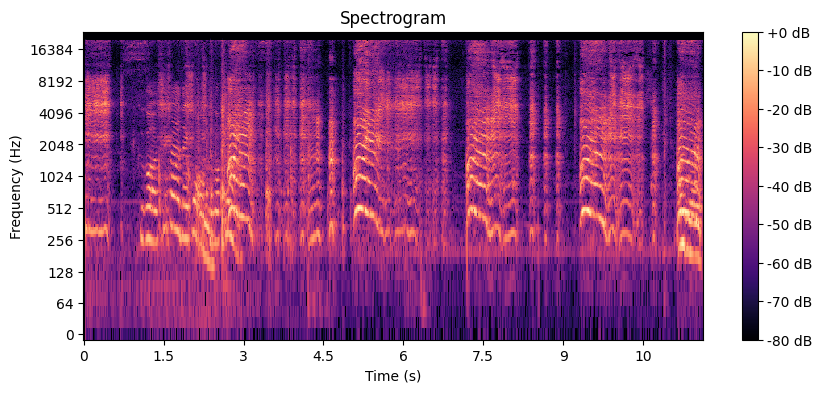

In [ ]:
# 스펙트로그램 그리기
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


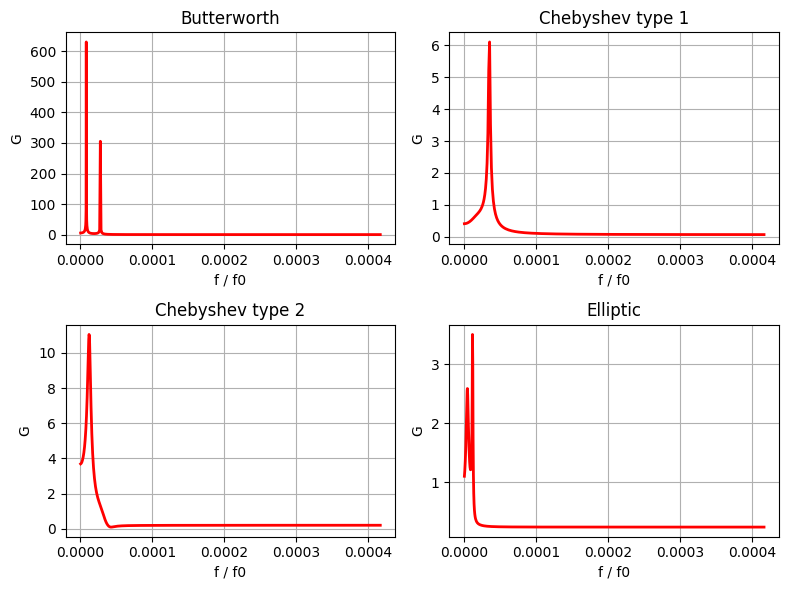

In [ ]:
# 필터 특성 정의
fs = sr  # 샘플링 레이트
nyquist = fs / 2
order = 4  # 필터 차수
cutoff = nyquist * 0.5  # 정규화된 컷오프 주파수

# 필터 설계
b_butter, a_butter = signal.butter(order, cutoff / nyquist, btype='low')
b_cheby1, a_cheby1 = signal.cheby1(order, 0.5, cutoff / nyquist, btype='low')
b_cheby2, a_cheby2 = signal.cheby2(order, 20, cutoff / nyquist, btype='low')
b_ellip, a_ellip = signal.ellip(order, 0.5, 20, cutoff / nyquist, btype='low')

# 필터 응답 계산
w, h_butter = signal.freqs(b_butter, a_butter)
_, h_cheby1 = signal.freqs(b_cheby1, a_cheby1)
_, h_cheby2 = signal.freqs(b_cheby2, a_cheby2)
_, h_ellip = signal.freqs(b_ellip, a_ellip)

# 필터 응답 그래프
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].plot(w / nyquist, np.abs(h_butter), 'r', linewidth=2)
axs[0, 0].set_title('Butterworth')

axs[0, 1].plot(w / nyquist, np.abs(h_cheby1), 'r', linewidth=2)
axs[0, 1].set_title('Chebyshev type 1')

axs[1, 0].plot(w / nyquist, np.abs(h_cheby2), 'r', linewidth=2)
axs[1, 0].set_title('Chebyshev type 2')

axs[1, 1].plot(w / nyquist, np.abs(h_ellip), 'r', linewidth=2)
axs[1, 1].set_title('Elliptic')

for ax in axs.flat:
    ax.set_xlabel('f / f0')
    ax.set_ylabel('G')
    ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
from scipy.signal import butter, filtfilt
import soundfile as sf
import IPython.display as ipd

hj_baby_mp32 = '/content/drive/MyDrive/Infant_crying_finetuning/sampl_audio_data_drive/움2.wav'
y, sr = librosa.load(hj_baby_mp32, sr=None)  # 원래 샘플링 레이트 유지

# Butterworth 밴드패스 필터 설계
lowcut = 0.1  # 정규화된 낮은 컷오프 주파수
highcut = 0.4 # 정규화된 높은 컷오프 주파수
order = 2     # 필터 차수

# Nyquist 주파수 계산
nyquist = sr / 2
low = lowcut * nyquist
high = highcut * nyquist

# 필터 계수 계산
b, a = butter(order, [low / nyquist, high / nyquist], btype='bandpass')

# 필터 적용
y_filtered = filtfilt(b, a, y)

# 원본 및 필터링된 오디오 스펙트로그램 비교
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 원본 스펙트로그램
D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='log', ax=axs[0])
axs[0].set_title('Original Spectrogram')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Frequency (Hz)')

# 필터링된 스펙트로그램
D_filt = librosa.amplitude_to_db(np.abs(librosa.stft(y_filtered)), ref=np.max)
librosa.display.specshow(D_filt, sr=sr, x_axis='time', y_axis='log', ax=axs[1])
axs[1].set_title('Filtered Spectrogram (Butterworth Bandpass)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


# 필터링된 오디오 저장
filtered_audio_path = "/content/filtered_audio.wav"
sf.write(filtered_audio_path, y_filtered, sr)

# 원본 오디오 재생
print("▶ 원본 오디오")
ipd.display(ipd.Audio(y, rate=sr))

# 필터링된 오디오 재생
print("▶ 필터링된 오디오")
ipd.display(ipd.Audio(y_filtered, rate=sr))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from scipy.signal import butter, filtfilt
import soundfile as sf
import IPython.display as ipd

hj_baby_mp33 = '/content/drive/MyDrive/Infant_crying_finetuning/sampl_audio_data_drive/움3.mp3'
y, sr = librosa.load(hj_baby_mp33, sr=None)  # 원래 샘플링 레이트 유지

# Butterworth 밴드패스 필터 설계
lowcut = 0.1  # 정규화된 낮은 컷오프 주파수
highcut = 0.4 # 정규화된 높은 컷오프 주파수
order = 2     # 필터 차수

# Nyquist 주파수 계산
nyquist = sr / 2
low = lowcut * nyquist
high = highcut * nyquist

# 필터 계수 계산
b, a = butter(order, [low / nyquist, high / nyquist], btype='bandpass')

# 필터 적용
y_filtered = filtfilt(b, a, y)

# 원본 및 필터링된 오디오 스펙트로그램 비교
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 원본 스펙트로그램
D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='log', ax=axs[0])
axs[0].set_title('Original Spectrogram')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Frequency (Hz)')

# 필터링된 스펙트로그램
D_filt = librosa.amplitude_to_db(np.abs(librosa.stft(y_filtered)), ref=np.max)
librosa.display.specshow(D_filt, sr=sr, x_axis='time', y_axis='log', ax=axs[1])
axs[1].set_title('Filtered Spectrogram (Butterworth Bandpass)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


# 필터링된 오디오 저장
filtered_audio_path = "/content/filtered_audio.wav"
sf.write(filtered_audio_path, y_filtered, sr)

# 원본 오디오 재생
print("▶ 원본 오디오")
ipd.display(ipd.Audio(y, rate=sr))

# 필터링된 오디오 재생
print("▶ 필터링된 오디오")
ipd.display(ipd.Audio(y_filtered, rate=sr))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sre_constants import SRE_FLAG_TEMPLATE
import numpy as np
import pandas as pd
import librosa
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU

def noise_reduction(audio_file_path):
    if audio_file_path.endswith('.wav') or audio_file_path.endswith('.mp3'):
        y, sr = librosa.load(hj_baby_mp32, sr=None)  # 원래 샘플링 레이트 유지

        # Butterworth 밴드패스 필터 설계
        lowcut = 0.1  # 정규화된 낮은 컷오프 주파수
        highcut = 0.4 # 정규화된 높은 컷오프 주파수
        order = 2     # 필터 차수

        # Nyquist 주파수 계산
        nyquist = sr / 2
        low = lowcut * nyquist
        high = highcut * nyquist

        # 필터 계수 계산
        b, a = butter(order, [low / nyquist, high / nyquist], btype='bandpass')

        # 필터 적용
        y_filtered = filtfilt(b, a, y)

    return y_filtered, SRE_FLAG_TEMPLATE


def feature_extractor_40(y, sr):

    mffcs_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs_features_40 = np.mean(mffcs_features.T, axis=0)

    # print('mfccs_features_40', mfccs_features_40.shape, mfccs_features_40)
    return mfccs_features_40


def feature_extractor_80(y, sr):

    mffcs_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=80)
    mfccs_features_80 = np.mean(mffcs_features.T, axis=0)

    # print('mfccs_features_40', mfccs_features_40.shape, mfccs_features_40)
    return mfccs_features_80

def scaler1(mfcc_features):
    scaler_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/first_model_scaler.pkl'
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    mfcc_features_scaled = scaler.transform([mfcc_features])

    return mfcc_features_scaled

def scaler2(mfcc_features):
    scaler_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/second_model_scaler.pkl'
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    mfcc_features_scaled = scaler.transform([mfcc_features])

    return mfcc_features_scaled

def differential_mfcc(mfcc_value):
    mfcc_features = np.array(mfcc_value)  # Pandas 값 변환 수정
    delta_mfccs = librosa.feature.delta(mfcc_features, order=1)         # ΔMFCC (1차 미분, 40개) 계산
    delta2_mfccs = librosa.feature.delta(mfcc_features, order=2)        # ΔΔMFCC (2차 미분, 40개) 계산

    concat_features = np.hstack((mfcc_features, delta_mfccs, delta2_mfccs))  # (샘플 수, 120)

    return concat_features

def process1(audio):
    audio_filtered, sr = noise_reduction(audio)
    mfcc1 = feature_extractor_40(audio_filtered, sr)
    if mfcc1 is None:
        return None
    mfcc2 = scaler1(mfcc1)
    mfcc3 = differential_mfcc(mfcc2)
    # print('first mfcc3', mfcc3.shape, mfcc3)
    return mfcc3

def process2(audio):
    audio_filtered, sr = noise_reduction(audio)
    mfcc1 = feature_extractor_80(audio_filtered, sr)
    if mfcc1 is None:
        return None
    mfcc2 = differential_mfcc(mfcc1)
    mfcc3 = scaler2(mfcc2)
    # print('second mfcc3', mfcc3.shape, mfcc3)
    return mfcc3


def model1(mfcc_features):
    # print('first_model_input', mfcc_features.shape, mfcc_features)
    model_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/first_model_sim1.keras'
    model = load_model(model_path, custom_objects={'LeakyReLU': LeakyReLU})  # 모델 로드

    pred = model.predict(mfcc_features)  # 예측 수행
    pred_class = (pred < 0.5).astype(int)  # 확률값을 이진 분류로 변환

    # if pred_class == 0:
    #     print('병원X')
    # else:
    #     print('병원O')

    return pred_class

def model2(mfcc_features):
    # print('second_model_input', mfcc_features.shape, mfcc_features)
    model_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/second_model_sim2_mfcc80.keras'
    model = load_model(model_path, custom_objects={'LeakyReLU': LeakyReLU})
    label_path = '/content/drive/MyDrive/Infant_crying_finetuning/artifacts/second_model_label_encoder.pkl'
    with open(label_path, 'rb') as f:
        label_encoder = pickle.load(f)

    pred = model.predict(mfcc_features)
    pred_class_index = np.argmax(pred)
    pred_class_name = label_encoder.inverse_transform([pred_class_index])[0]

    # if pred_class_index == 0:
    #     print('awake, 깸')
    # elif pred_class_index == 1:
    #     print('diaper, 귀저기갈아야함')
    # elif pred_class_index == 2:
    #     print('hug, 안아줘야함')
    # elif pred_class_index == 3:
    #     print('hungry, 배고픔')
    # elif pred_class_index == 4:
    #     print('sleepy, 졸림')
    # else:
    #     print('모델예측잘못됨')
    return pred_class_name


def pipeline(audio_file_path):
    mfcc1 = process1(audio_file_path)
    mfcc2 = process2(audio_file_path)
    pred1 = model1(mfcc1)
    pred2 = model2(mfcc2)

    print('최종결과-------------')
    if pred1 == 0:
        print(pred2)
    else:
        print('당장 병원 ㄱㄱ')


In [ ]:
hj_baby_mp31 = '/content/drive/MyDrive/Infant_crying_finetuning/sampl_audio_data_drive/움1.wav'

pipeline( hj_baby_mp31)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
최종결과-------------
diaper


In [ ]:
hj_baby_mp32 = '/content/drive/MyDrive/Infant_crying_finetuning/sampl_audio_data_drive/움2.wav'

pipeline( hj_baby_mp32)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
최종결과-------------
diaper


In [ ]:
hj_baby_mp33 = '/content/drive/MyDrive/Infant_crying_finetuning/sampl_audio_data_drive/움3.mp3'

pipeline( hj_baby_mp33)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
최종결과-------------
diaper


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

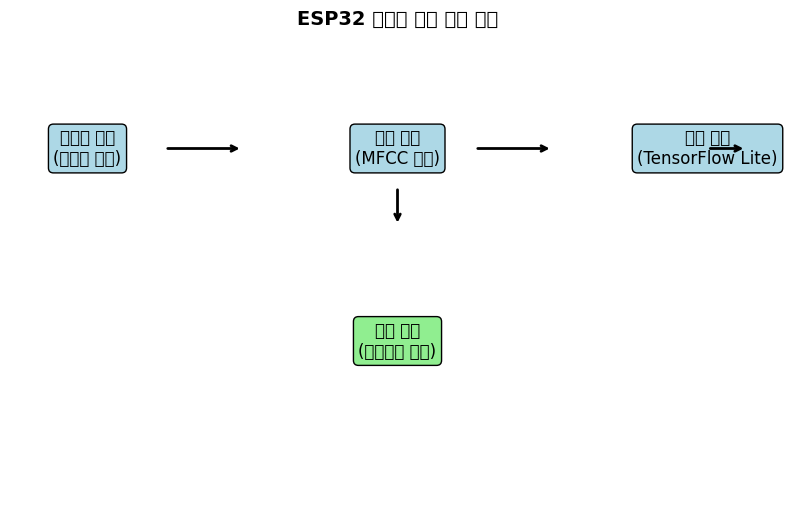

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 다이어그램 크기 설정
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# 박스 스타일 설정
box_style = dict(facecolor="lightblue", edgecolor="black", boxstyle="round,pad=0.3")

# 주요 블록 추가
ax.text(1, 4.5, "오디오 수집\n(마이크 입력)", ha="center", va="center", fontsize=12, bbox=box_style)
ax.text(5, 4.5, "특징 추출\n(MFCC 변환)", ha="center", va="center", fontsize=12, bbox=box_style)
ax.text(9, 4.5, "모델 실행\n(TensorFlow Lite)", ha="center", va="center", fontsize=12, bbox=box_style)

# 화살표 추가
ax.annotate("", xy=(3, 4.5), xytext=(2, 4.5), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(7, 4.5), xytext=(6, 4.5), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(9.5, 4.5), xytext=(9, 4.5), arrowprops=dict(arrowstyle="->", lw=2))

# 결과 박스 추가
ax.text(5, 2, "출력 결과\n(울음소리 분류)", ha="center", va="center", fontsize=12,
        bbox=dict(facecolor="lightgreen", edgecolor="black", boxstyle="round,pad=0.3"))

# 화살표 추가 (아래로)
ax.annotate("", xy=(5, 3.5), xytext=(5, 4), arrowprops=dict(arrowstyle="->", lw=2))

# 다이어그램 표시
plt.title("ESP32 오디오 분석 주요 흐름", fontsize=14, fontweight="bold")
plt.show()
